<a href="https://colab.research.google.com/github/joaoadavid/GA-PER90/blob/main/AvaliacaoN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Avaliação N3 — Ciência de dados com MongoDB e Regressão

**Disciplina:** Ciência de dados
**Curso:** Engenharia de Software  
**Professor:** Paulo Manseira  
**Aluno:** João Antonio David  

---

Este notebook implementa a **Avaliação N3**, utilizando:

- Dataset de estatísticas de jogadores de futebol da temporada **2024–2025**;
- **MongoDB** como repositório NoSQL para armazenamento e consultas;
- **Python (pandas, scikit-learn)** para EDA e modelagem preditiva.

A pergunta central é:

> **Quais métricas de participação em jogo e contribuição técnica — como minutos jogados, conduções progressivas, distância carregada com bola, precisão de passes e passes-chave — são os melhores preditores do desempenho ofensivo (gols, assistências, xG + xAG) de um jogador nas principais ligas europeias na temporada 2024–2025?**



## 1) Domínio, Pergunta de Negócio e Objetivo do Modelo

### 1.1 Domínio do Problema
1. Domínio do Problema

O domínio investigado neste estudo é o futebol de alto rendimento nas principais ligas europeias durante a temporada 2024–2025, abrangendo competições como Premier League, La Liga, Serie A, Bundesliga e Ligue 1. Cada observação representa um jogador profissional com um conjunto extenso de métricas referentes à participação em campo, posse e condução de bola, criação de chances e produção ofensiva.

O tema justifica-se pela importância crescente da análise preditiva aplicada ao esporte, particularmente no contexto de scouting, suporte à tomada de decisão e avaliação objetiva do desempenho ofensivo de atletas.

Cada linha do dataset representa um jogador, com estatísticas de:
- participação (minutos, jogos, 90s);
- posse e condução de bola (toques, conduções, passes progressivos);
- criação de chances (passes-chave, xG, xAG);
- produção ofensiva (gols, assistências, `npxG+xAG`).

---

### 1.2 Pergunta de Negócio

> **"A questão norteadora deste trabalho é formulada da seguinte forma:

Quais métricas de participação em jogo e contribuição técnica — tais como conduções progressivas, distância carregada com bola, passes-chave e volume de toques — são capazes de predizer o desempenho ofensivo (GA_per90) de jogadores atuando nas principais ligas europeias na temporada 2024–2025?**

Esta formulação permite investigar a relevância estatística de diferentes atributos técnicos para explicar variações no impacto ofensivo dos atletas.

---

### 1.3 Objetivo do Modelo

O objetivo deste estudo é desenvolver e avaliar um modelo preditivo de regressão capaz de estimar a métrica GA_per90 (gols + assistências por 90 minutos) a partir de variáveis relacionadas à:

participação em ações com a bola;
criação de oportunidades ofensivas;
conduções e progressões em campo adversário;
qualidade das finalizações (npxG);
informações demográficas (idade) e competitivas (posição e liga).

O modelo final visa fornecer uma ferramenta objetiva para análise comparativa de desempenho ofensivo, podendo ser integrada a processos de scouting, análise tática ou decisões de contratação.

Esse modelo servirá como ferramenta analítica para:

- **scouting** e identificação de talentos;
- avaliação de impacto ofensivo de jogadores;
- apoio a decisões em contratações e escalações.



## 4) Arquitetura de Dados e Fonte


### Fonte dos Dados
- **Kaggle Dataset:** *Football players stats 2024–2025*  
  Link: https://www.kaggle.com/datasets/hubertsidorowicz/football-players-stats-2024-2025  

Arquivos utilizados neste notebook:

- **Base bruta:** `players_data-2024_2025.csv`  
- **Base limpa:** `players_stats.csv`

Um Data Lakehouse simplificado foi adotado como arquitetura do repositório de dados. O pipeline é organizado nas seguintes camadas:

4.1 Camada Raw

Armazena o arquivo original proveniente do dataset do Kaggle, contendo aproximadamente 267 colunas com estatísticas diversas de jogadores.

4.2 Camada Processed

A partir do arquivo bruto, aplica-se um processo de limpeza que:
remove jogadores sem tempo de jogo ou com dados incompletos;
converte tipos inconsistentes;
padroniza nomes de colunas;
constrói métricas normalizadas por 90 minutos;
seleciona aproximadamente 30 variáveis relevantes para o problema.

4.3 Camada Analytics (MongoDB)
A base processada é inserida na coleção players do banco leagues, no MongoDB.
São criados índices sobre atributos de interesse (Player, Comp, Pos, Gls_per90), viabilizando consultas analíticas eficientes.


4.4 Fluxo Geral do Pipeline
Kaggle CSV (Raw)
         ↓
Limpeza, padronização e seleção (Processed)
         ↓
Armazenamento no MongoDB (Analytics)
         ↓
Exportação para Pandas → EDA → Modelagem
         ↓
Treinamento, avaliação e deploy do modelo
Essa organização permite independência entre ingestão, análise e modelagem, além de facilitar reprodutibilidade.

# Instalação das Bibliotecas e Conexão com o MongoDB

Para o processamento dos dados e armazenamento analítico, foram instaladas as bibliotecas essenciais para manipulação, visualização e modelagem, incluindo pymongo, pandas, numpy, seaborn, matplotlib e joblib. A seguir, realizou-se a configuração da conexão com o MongoDB local, que desempenha o papel de camada Analytics do Data Lakehouse.

In [ ]:

!pip -q install pymongo pandas gdown


In [ ]:
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo apt-key add -
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
!apt-get update -y >/dev/null
!apt-get install -y mongodb-org >/dev/null

!mkdir -p /content/data/db
!mkdir -p /content/log/mongo

!mongod --dbpath /content/data/db --bind_ip 127.0.0.1 --port 27017 --fork --logpath /content/log/mongo/mongod.log
!sleep 2
!tail -n 5 /content/log/mongo/mongod.log

OK
deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse
W: https://repo.mongodb.org/apt/ubuntu/dists/jammy/mongodb-org/6.0/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
about to fork child process, waiting until server is ready for connections.
forked process: 63668
ERROR: child process failed, exited with 48
To see additional information in this output, start without the "--fork" option.
{"t":{"$date":"2025-12-02T03:42:17.934+00:00"},"s":"I",  "c":"CONTROL",  "id":4784929, "ctx":"initandlisten","msg":"Acquiring the global lock for shutdown"}
{"t":{"$date":"2025-12-02T03:42:17.934+00:00"},"s":"I",  "c":"-",        "id":4784931, "ctx":"initandlisten","msg":"Dropping the scop

In [ ]:

# 4) Instalação de Bibliotecas Python e Conexão com o MongoDB

!pip -q install "pymongo[srv]" pandas numpy seaborn matplotlib joblib

from pymongo import MongoClient
from pymongo.errors import ServerSelectionTimeoutError

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sns.set()
pd.set_option("display.max_columns", 200)

MONGO_URI = "mongodb://127.0.0.1:27017"

client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)

try:
    client.admin.command("ping")
    print("✅ Conectado ao MongoDB local em", MONGO_URI)
except ServerSelectionTimeoutError as e:
    raise SystemExit("❌ Não foi possível conectar ao MongoDB.\n" + str(e))

db = client["leagues"]
players_col = db["players"]

print("Banco de dados:", db.name)
print("Coleção:", players_col.name)


✅ Conectado ao MongoDB local em mongodb://127.0.0.1:27017
Banco de dados: leagues
Coleção: players


#5) Ingestão das Bases Bruta e Limpa

Os arquivos referentes ao dataset de jogadores foram armazenados previamente no Google Drive e transferidos ao ambiente de execução via gdown. A base bruta contém todas as 267 colunas originais, enquanto a base limpa representa o resultado de etapas anteriores de processamento.

In [ ]:
import os
import gdown
import pandas as pd

# IDs dos arquivos no Google Drive
FILE_CLEAN_ID = "1OLSwvt3Fw2ZzigvkSXWo6aWXx7RFM-JN"
FILE_RAW_ID   = "14OD_Hz62ScDxyAMO-PCB5hiuFrxHndsa"

# Caminhos de saída
CLEAN_PATH = "players_stats_limpo.csv"
RAW_PATH   = "players_data-2024_2025.csv"

# URLs para download
url_clean = f"https://drive.google.com/uc?id={FILE_CLEAN_ID}"
url_raw   = f"https://drive.google.com/uc?id={FILE_RAW_ID}"

print("⬇️ Baixando bases...")
gdown.download(url_clean, CLEAN_PATH, quiet=False)
gdown.download(url_raw, RAW_PATH, quiet=False)

# Verifica se ambos os arquivos existem
if os.path.exists(CLEAN_PATH) and os.path.exists(RAW_PATH):

    df_clean = pd.read_csv(CLEAN_PATH)
    df_raw = pd.read_csv(RAW_PATH)

    print("\n✅ Bases carregadas com sucesso!")
    print(f"Base limpa shape: {df_clean.shape}")
    print(f"Base bruta shape: {df_raw.shape}\n")

    print("📌 Amostra da base limpa:")
    display(df_clean.head(3))

    print("📌 Amostra da base bruta:")
    display(df_raw.head(3))

else:
    print("❌ Falha ao baixar os arquivos. Verifique os IDs.")


⬇️ Baixando bases...


Downloading...
From: https://drive.google.com/uc?id=1OLSwvt3Fw2ZzigvkSXWo6aWXx7RFM-JN
To: /content/players_stats_limpo.csv
100%|██████████| 414k/414k [00:00<00:00, 32.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=14OD_Hz62ScDxyAMO-PCB5hiuFrxHndsa
To: /content/players_data-2024_2025.csv
100%|██████████| 2.65M/2.65M [00:00<00:00, 96.7MB/s]



✅ Bases carregadas com sucesso!
Base limpa shape: (1982, 30)
Base bruta shape: (2854, 267)

📌 Amostra da base limpa:


,Player,Pos,Squad,Comp,Age,Min,90s,Carries,PrgDist_stats_possession,PrgC_stats_possession,Touches,Att 3rd_stats_possession,Succ,Cmp%,PrgP,KP,Gls,Ast,xG,xAG,npxG,npxG+xAG,CrdY,CrdR,Touches_per90,Carries_per90,PrgP_per90,KP_per90,Gls_per90,Ast_per90
0,Yunis Abdelhamid,DF,Saint-Étienne,fr Ligue 1,36.0,1033,11.5,322,837,4,641,14,3,86.7,22,2,0,0,0.2,0.1,0.2,0.4,2,0,55.739130,28.000000,1.913043,0.173913,0.000000,0.000000
1,Himad Abdelli,"MF,FW",Angers,fr Ligue 1,24.0,2842,31.6,1183,4388,107,1993,597,57,82.1,207,39,6,1,6.4,3.2,3.2,6.4,4,0,63.069620,37.436709,6.550633,1.234177,0.189873,0.031646
2,Mohamed Abdelmoneim,DF,Nice,fr Ligue 1,25.0,855,9.5,342,822,6,635,46,1,90.4,52,0,0,0,0.0,0.0,0.0,0.0,2,0,66.842105,36.000000,5.473684,0.000000,0.000000,0.000000


📌 Amostra da base bruta:


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,G+A-PK,xG+xAG,Rk_stats_shooting,Nation_stats_shooting,Pos_stats_shooting,Comp_stats_shooting,Age_stats_shooting,Born_stats_shooting,90s_stats_shooting,Gls_stats_shooting,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK_stats_shooting,PKatt_stats_shooting,xG_stats_shooting,npxG_stats_shooting,npxG/Sh,G-xG,np:G-xG,Rk_stats_passing,Nation_stats_passing,Pos_stats_passing,Comp_stats_passing,Age_stats_passing,Born_stats_passing,90s_stats_passing,Cmp,Att,Cmp%,TotDist,PrgDist,Ast_stats_passing,xAG_stats_passing,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP_stats_passing,Rk_stats_passing_types,Nation_stats_passing_types,Pos_stats_passing_types,Comp_stats_passing_types,Age_stats_passing_types,Born_stats_passing_types,90s_stats_passing_types,Att_stats_passing_types,Live,Dead,FK_stats_passing_types,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp_stats_passing_types,Off,Blocks,Rk_stats_gca,Nation_stats_gca,Pos_stats_gca,Comp_stats_gca,...,Comp_stats_playing_time,Age_stats_playing_time,Born_stats_playing_time,MP_stats_playing_time,Min_stats_playing_time,Mn/MP,Min%,90s_stats_playing_time,Starts_stats_playing_time,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,Rk_stats_misc,Nation_stats_misc,Pos_stats_misc,Comp_stats_misc,Age_stats_misc,Born_stats_misc,90s_stats_misc,CrdY_stats_misc,CrdR_stats_misc,2CrdY,Fls,Fld_stats_misc,Off_stats_misc,Crs_stats_misc,Int_stats_misc,TklW_stats_misc,PKwon,PKcon,OG,Recov,Won,Lost_stats_misc,Won%,Rk_stats_keeper,Nation_stats_keeper,Pos_stats_keeper,Comp_stats_keeper,Age_stats_keeper,Born_stats_keeper,MP_stats_keeper,Starts_stats_keeper,Min_stats_keeper,90s_stats_keeper,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKatt_stats_keeper,PKA,PKsv,PKm,Rk_stats_keeper_adv,Nation_stats_keeper_adv,Pos_stats_keeper_adv,Comp_stats_keeper_adv,Age_stats_keeper_adv,Born_stats_keeper_adv,90s_stats_keeper_adv,GA_stats_keeper_adv,PKA_stats_keeper_adv,FK_stats_keeper_adv,CK_stats_keeper_adv,OG_stats_keeper_adv,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp_stats_keeper_adv,Att_stats_keeper_adv,Cmp%_stats_keeper_adv,Att (GK),Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,2000.0,3,1,86,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,8,3,0.0,0.00,1,eng ENG,DF,eng Premier League,24.0,2000.0,1.0,0,0,0,NaN,0.00,0.0,NaN,NaN,NaN,0,0,0,0.0,0.0,NaN,0.0,0.0,1,eng ENG,DF,eng Premier League,24.0,2000.0,1.0,50,63,79.4,887,361,0,0.0,0.0,0.0,0,8,0,0,8,1,eng ENG,DF,eng Premier League,24.0,2000.0,1.0,63,51,12,2,0,0,2,10,0,0,0,0,50,0,1,1,eng ENG,DF,eng Premier League,...,eng Premier League,24.0,2000.0,3,86,29,2.5,1.0,1,61.0,0,2,13.0,11,0.67,2,0,2,2.09,1.82,2.3,0.3,2.0,2.12,1,eng ENG,DF,eng Premier League,24.0,2000.0,1.0,0,0,0,0,2,0,2,1,2,0,0,0,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,24.0,2000.0,4,1,120,1.3,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0,6,10,0.0,0.02,2,eng ENG,"DF,MF",es La Liga,24.0,2000.0,1.3,0,0,0,NaN,0.00,0.0,NaN,NaN,NaN,0,0,0,0.0,0.0,NaN,0.0,0.0,2,eng ENG,"DF,MF",es La Liga,24.0,2000.0,1.3,47,66,71.2,705,190,0,0.0,0.0,0.0,1,2,0,0,6,2,eng ENG,"DF,MF",es La Liga,24.0,2000.0,1.3,66,54,12,1,0,0,5,11,0,0,0,0,47,0,1,2,eng ENG,"DF,MF",es La Liga,...,es La Liga,24.0,2000.0,4,120,30,3.5,1.3,1,73.0,0,3,16.0,14,0.75,1,3,-2,-1.50,-1.28,1.5,3.7,-2.3,-1.69,2,eng ENG,"DF,MF",es La Liga,24.0,2000.0,1.3,2,0,0,0,2,0,5,0,4,0,0,0,7,2,1,66.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,2003.0,1,1,65,0.7,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,2,3,0.0,0

# 5.1 Síntese do Processo de Limpeza e Transformação (Bruto → Limpo)

A transformação da base bruta para a base limpa envolveu um conjunto estruturado de procedimentos com o objetivo de garantir consistência, interpretabilidade e adequação ao problema analítico. A seguir, apresenta-se um resumo das principais ações:

Redução de Linhas

Base bruta: aproximadamente 2.854 registros
Base limpa: aproximadamente 1.982 registros
A redução ocorreu pela exclusão de jogadores:
sem minutos disputados na temporada;
com informações essenciais ausentes ou inválidas.
Redução de Colunas
Base bruta: 267 colunas

Base limpa: cerca de 30 colunas
Mantiveram-se apenas variáveis relacionadas à:
participação em posse de bola;
conduções e progressões;
criação de chances;
métricas ofensivas (gols, assistências, xG, xAG);
informações contextuais (posição, liga).

#Principais Etapas da Limpeza
1. Remoção de atributos irrelevantes ou redundantes

Foram excluídas:
estatísticas puramente defensivas;
métricas específicas de goleiros;
indicadores altamente redundantes ou de baixa utilidade para modelagem ofensiva;
percentuais que não agregavam valor interpretativo.

2. Padronização dos nomes das variáveis
Procedimentos aplicados:
remoção de espaços e caracteres especiais;
uniformização de padrões de nomenclatura;
simplificação de identificadores complexos.

3. Correção e conversão de tipos

Diversas colunas importadas como string foram corretamente convertidas para:
float;
int.

Esse ajuste assegurou a integridade das operações matemáticas posteriores.

4. Construção de métricas normalizadas por 90 minutos
Com o objetivo de comparar jogadores de diferentes tempos de atuação, foram criadas métricas per-90 como:
Touches_per90
Carries_per90
PrgP_per90
KP_per90
Gls_per90
Ast_per90

5. Tratamento de valores ausentes e outliers

Incluiu:
remoção de registros com Min = 0 ou métricas essenciais ausentes;
truncagem no percentil 99 em algumas variáveis de volume, reduzindo o impacto de outliers extremos sem distorcer a distribuição original.

In [ ]:

# Ajustes Finais da Base Limpa (garantia de tipos e nulos)

df = df_clean.copy()

print("Colunas da base limpa:")
print(df.columns.tolist())

maybe_numeric = [
    "Age","Min","90s","Touches","Carries","PrgP","KP",
    "Gls","Ast","xG","xAG","npxG","npxG+xAG",
    "Touches_per90","Carries_per90","PrgP_per90","KP_per90",
    "Gls_per90","Ast_per90"
]

for col in maybe_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Removendo registros sem minutos ou sem métricas ofensivas essenciais
df = df.dropna(subset=["Min","90s","Gls_per90","Ast_per90"])
print("Formato após limpeza leve:", df.shape)

df.info()


Colunas da base limpa:
['Player', 'Pos', 'Squad', 'Comp', 'Age', 'Min', '90s', 'Carries', 'PrgDist_stats_possession', 'PrgC_stats_possession', 'Touches', 'Att 3rd_stats_possession', 'Succ', 'Cmp%', 'PrgP', 'KP', 'Gls', 'Ast', 'xG', 'xAG', 'npxG', 'npxG+xAG', 'CrdY', 'CrdR', 'Touches_per90', 'Carries_per90', 'PrgP_per90', 'KP_per90', 'Gls_per90', 'Ast_per90']
Formato após limpeza leve: (1982, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Player                    1982 non-null   object 
 1   Pos                       1982 non-null   object 
 2   Squad                     1982 non-null   object 
 3   Comp                      1982 non-null   object 
 4   Age                       1980 non-null   float64
 5   Min                       1982 non-null   int64  
 6   90s                       1982 non-null   float64

#5) Ajustes Finais da Base Limpa

Após o carregamento da base limpa, procedeu-se aos ajustes finais necessários para garantir a consistência dos tipos de dados e eliminar eventuais registros incompletos. As colunas potencialmente numéricas foram convertidas explicitamente para tipos numéricos, com coerção de valores inválidos para NaN, a fim de evitar conflitos nas etapas posteriores de análise e modelagem.

#6) Inserção da Base Processada no MongoDB

A base limpa foi então inserida na coleção players do banco leagues, compondo a camada Analytics da arquitetura Data Lakehouse. Antes da inserção, a coleção foi completamente esvaziada para garantir reprodutibilidade. Registros contendo valores ausentes foram adequadamente convertidos para None para assegurar compatibilidade com o formato BSON.

In [ ]:

# Inserção da Base Limpa no MongoDB (leagues.players)

from pymongo import ASCENDING, DESCENDING

# Limpa a coleção antes de inserir
players_col.drop()
print("Coleção 'players' limpa.")

# Substitui NaN por None para compatibilidade com BSON
docs = df.replace({np.nan: None}).to_dict(orient="records")

BATCH = 1000
for i in range(0, len(docs), BATCH):
    players_col.insert_many(docs[i:i+BATCH])

print("Documentos inseridos em leagues.players:", players_col.count_documents({}))

# Criação de índices úteis
players_col.create_index([("Player", ASCENDING)], name="idx_player")
players_col.create_index([("Comp", ASCENDING), ("Squad", ASCENDING)], name="idx_comp_squad")
players_col.create_index([("Pos", ASCENDING)], name="idx_pos")
players_col.create_index([("Gls_per90", DESCENDING)], name="idx_gls_per90")

print("\nÍndices criados:")
for ix in players_col.list_indexes():
    print(" -", ix["name"])


Coleção 'players' limpa.
Documentos inseridos em leagues.players: 1982

Índices criados:
 - _id_
 - idx_player
 - idx_comp_squad
 - idx_pos
 - idx_gls_per90


7) Consultas Exemplares no MongoDB

A coleção leagues.players permite uma série de consultas analíticas diretamente no banco NoSQL. Entre as consultas demonstradas, destacam-se:

identificação dos top 5 goleadores por 90 minutos por liga;

cálculo da média de passes-chave por posição;

análises descritivas agregadas para fins exploratórios.

In [ ]:
pipeline_top_scorers = [
    {"$match": {"Min": {"$gte": 900}, "Gls_per90": {"$ne": None}}},
    {"$sort": {"Comp": 1, "Gls_per90": -1}},
    {"$group": {
        "_id": "$Comp",
        "top": {
            "$push": {
                "Player": "$Player",
                "Squad": "$Squad",
                "Pos": "$Pos",
                "Gls_per90": "$Gls_per90"
            }
        }
    }},
    {"$project": {
        "_id": 0,
        "Comp": "$_id",
        "top_scorers": {"$slice": ["$top", 5]}
    }}
]

top_scorers_result = list(players_col.aggregate(pipeline_top_scorers))
top_scorers_result[:3]

[{'Comp': 'de Bundesliga',
  'top_scorers': [{'Player': 'Patrik Schick',
    'Squad': 'Leverkusen',
    'Pos': 'FW',
    'Gls_per90': 1.1229946524064172},
   {'Player': 'Harry Kane',
    'Squad': 'Bayern Munich',
    'Pos': 'FW',
    'Gls_per90': 0.981132075471698},
   {'Player': 'Omar Marmoush',
    'Squad': 'Eint Frankfurt',
    'Pos': 'FW',
    'Gls_per90': 0.9316770186335402},
   {'Player': 'Myron Boadu',
    'Squad': 'Bochum',
    'Pos': 'FW',
    'Gls_per90': 0.7758620689655172},
   {'Player': 'Jonathan Burkardt',
    'Squad': 'Mainz 05',
    'Pos': 'FW',
    'Gls_per90': 0.7692307692307693}]},
 {'Comp': 'fr Ligue 1',
  'top_scorers': [{'Player': 'Ousmane Dembélé',
    'Squad': 'Paris S-G',
    'Pos': 'FW',
    'Gls_per90': 1.09375},
   {'Player': 'Mika Biereth',
    'Squad': 'Monaco',
    'Pos': 'FW',
    'Gls_per90': 0.9558823529411764},
   {'Player': 'Amine Gouiri',
    'Squad': 'Marseille',
    'Pos': 'FW,MF',
    'Gls_per90': 0.8620689655172414},
   {'Player': 'Gonçalo Ramos

In [ ]:

# Média de KP_per90 por posição (Pos)

pipeline_kp_pos = [
    {"$match": {"KP_per90": {"$ne": None}}},
    {"$group": {
        "_id": "$Pos",
        "avg_kp90": {"$avg": "$KP_per90"},
        "count": {"$sum": 1}
    }},
    {"$sort": {"avg_kp90": -1}}
]

list(players_col.aggregate(pipeline_kp_pos))


[{'_id': 'MF,FW', 'avg_kp90': 1.4593935109850964, 'count': 151},
 {'_id': 'FW,MF', 'avg_kp90': 1.4360311609760679, 'count': 221},
 {'_id': 'FW,DF', 'avg_kp90': 1.2870319740388239, 'count': 9},
 {'_id': 'FW', 'avg_kp90': 1.0865915585948571, 'count': 227},
 {'_id': 'DF,FW', 'avg_kp90': 1.0564745745481845, 'count': 38},
 {'_id': 'MF', 'avg_kp90': 1.0366829107294846, 'count': 402},
 {'_id': 'MF,DF', 'avg_kp90': 0.9725797903424173, 'count': 56},
 {'_id': 'DF,MF', 'avg_kp90': 0.9181746796393834, 'count': 76},
 {'_id': 'DF', 'avg_kp90': 0.509710231546648, 'count': 647},
 {'_id': 'GK', 'avg_kp90': 0.030346672263533516, 'count': 155}]

# 8) Carregamento da Base do MongoDB para EDA e Modelagem

A base armazenada no MongoDB foi carregada novamente em um DataFrame Pandas para execução da EDA e preparação da modelagem.
Removem-se os identificadores BSON e reconvertem-se colunas numéricas, assegurando integridade para o fluxo de modelagem.

Além disso, cria-se a variável derivada GA_per90, utilizada como alvo dos modelos preditivos.

In [ ]:

# Carregando os Dados do MongoDB para Pandas (para EDA e Modelagem)

cursor = players_col.find({})
df_mongo = pd.DataFrame(list(cursor))

print("DF vindo do Mongo:", df_mongo.shape)
display(df_mongo.head(3))

# Remove _id e garante tipos numéricos
if "_id" in df_mongo.columns:
    df_mongo = df_mongo.drop(columns=["_id"])

for col in maybe_numeric:
    if col in df_mongo.columns:
        df_mongo[col] = pd.to_numeric(df_mongo[col], errors="coerce")

# Cria coluna GA_per90 = Gls_per90 + Ast_per90
if {"Gls_per90","Ast_per90"}.issubset(df_mongo.columns):
    df_mongo["GA_per90"] = df_mongo["Gls_per90"] + df_mongo["Ast_per90"]

df_mongo = df_mongo.dropna(subset=["GA_per90"])

print("Formato após criação de GA_per90 e remoção de nulos:", df_mongo.shape)


DF vindo do Mongo: (1982, 31)


,_id,Player,Pos,Squad,Comp,Age,Min,90s,Carries,PrgDist_stats_possession,PrgC_stats_possession,Touches,Att 3rd_stats_possession,Succ,Cmp%,PrgP,KP,Gls,Ast,xG,xAG,npxG,npxG+xAG,CrdY,CrdR,Touches_per90,Carries_per90,PrgP_per90,KP_per90,Gls_per90,Ast_per90
0,692e602b9b72c87cf7635d29,Yunis Abdelhamid,DF,Saint-Étienne,fr Ligue 1,36.0,1033,11.5,322,837,4,641,14,3,86.7,22,2,0,0,0.2,0.1,0.2,0.4,2,0,55.739130,28.000000,1.913043,0.173913,0.000000,0.000000
1,692e602b9b72c87cf7635d2a,Himad Abdelli,"MF,FW",Angers,fr Ligue 1,24.0,2842,31.6,1183,4388,107,1993,597,57,82.1,207,39,6,1,6.4,3.2,3.2,6.4,4,0,63.069620,37.436709,6.550633,1.234177,0.189873,0.031646
2,692e602b9b72c87cf7635d2b,Mohamed Abdelmoneim,DF,Nice,fr Ligue 1,25.0,855,9.5,342,822,6,635,46,1,90.4,52,0,0,0,0.0,0.0,0.0,0.0,2,0,66.842105,36.000000,5.473684,0.000000,0.000000,0.000000


Formato após criação de GA_per90 e remoção de nulos: (1982, 31)


# 9) Análise Exploratória dos Dados (EDA)

A EDA buscou compreender o comportamento das variáveis explicativas e sua relação com o desempenho ofensivo dos jogadores. Essa etapa é essencial para orientar decisões de engenharia de atributos e seleção de modelos.

9.1 Distribuição das métricas ofensivas

As distribuições de Gls_per90, Ast_per90 e GA_per90 mostraram forte assimetria à direita, coerente com a concentração de produção ofensiva em poucos atletas.

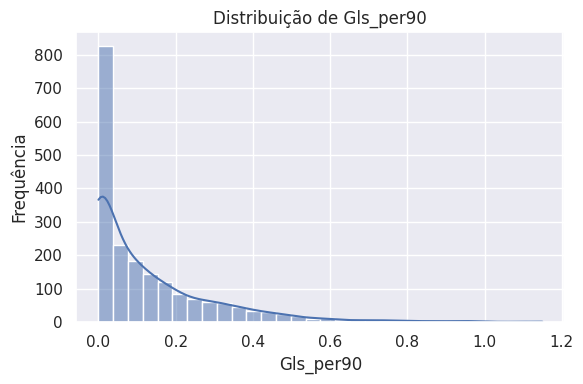

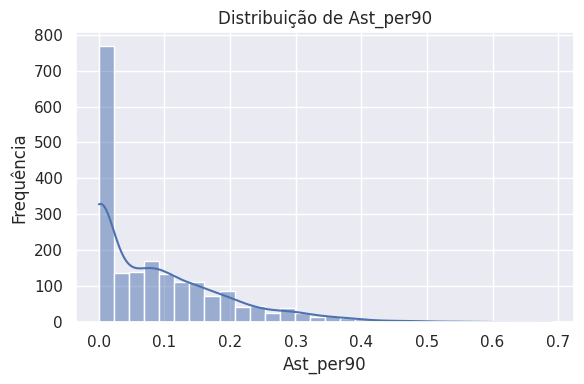

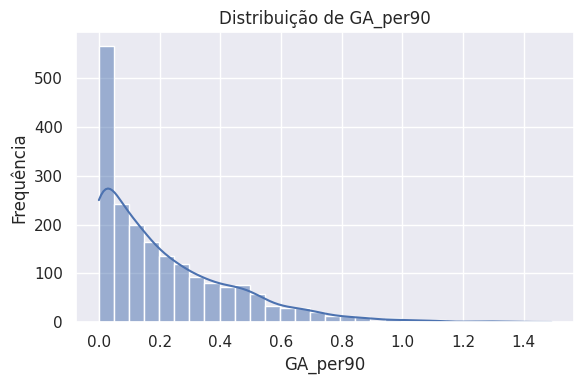

In [ ]:


targets = ["Gls_per90","Ast_per90","GA_per90"]

for col in targets:
    if col in df_mongo.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_mongo[col].dropna(), kde=True, bins=30)
        plt.title(f"Distribuição de {col}")
        plt.xlabel(col)
        plt.ylabel("Frequência")
        plt.tight_layout()
        plt.show()


# 9.2 Relações entre variáveis explicativas e GA_per90

Gráficos de dispersão mostraram correlações positivas entre GA_per90 e variáveis como:

conduções por 90 (Carries_per90);

passes progressivos (PrgP_per90);

passes-chave (KP_per90);

volume de toques (Touches_per90);

qualidade das finalizações (npxG)

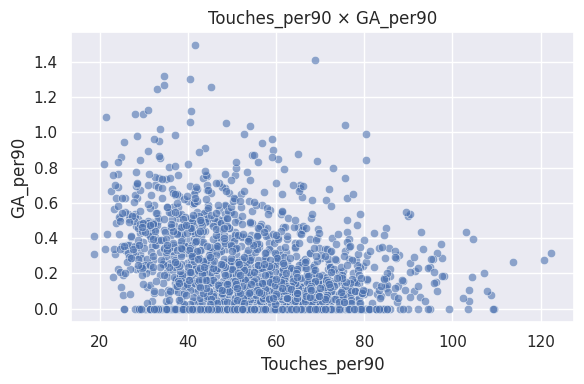

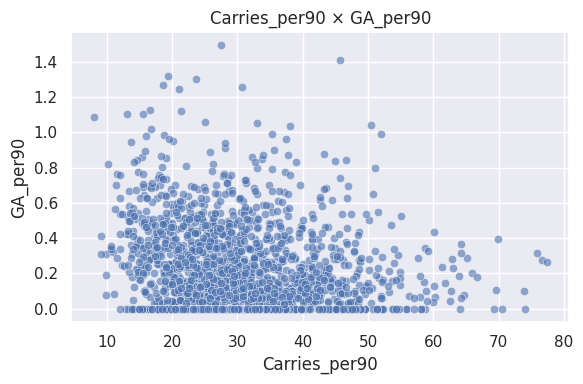

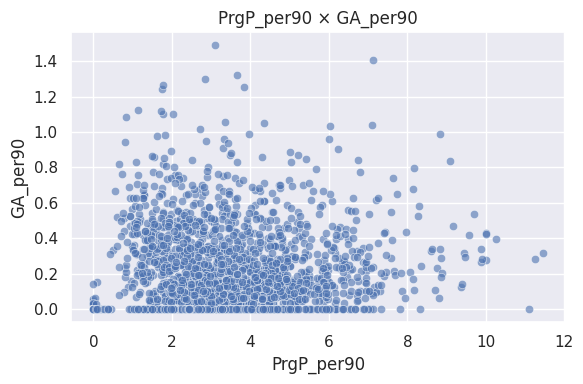

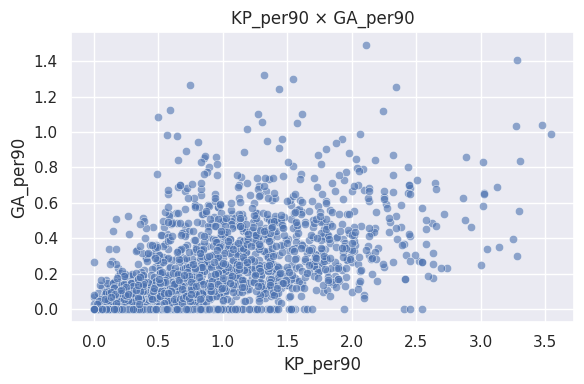

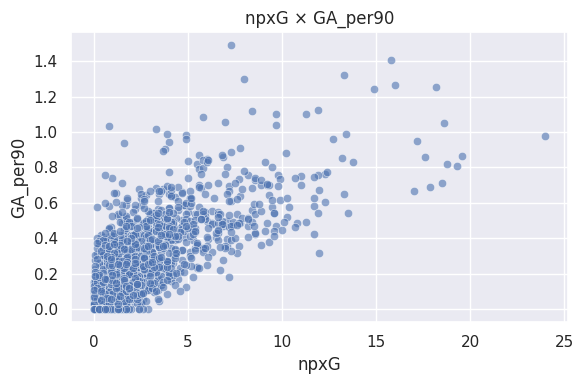

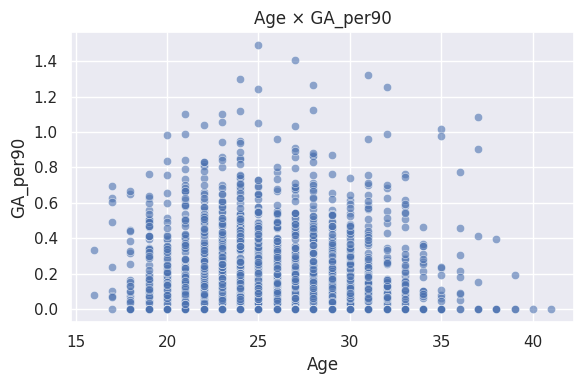

In [ ]:

# Relações entre métricas numéricas e GA_per90

candidates = ["Touches_per90","Carries_per90","PrgP_per90","KP_per90","npxG","Age"]
target = "GA_per90"

for col in candidates:
    if col in df_mongo.columns and target in df_mongo.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df_mongo[col], y=df_mongo[target], alpha=0.6)
        plt.title(f"{col} × {target}")
        plt.xlabel(col)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()


9.3 Análise por posição

A distribuição de GA_per90 por posição mostrou, conforme esperado, maior produção ofensiva em atletas classificados como atacantes (FW).

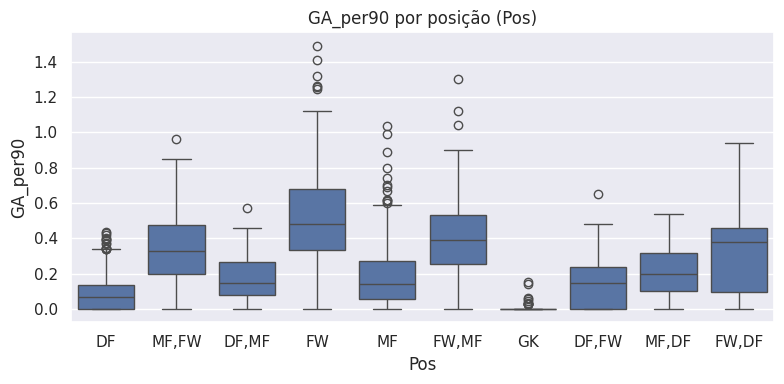

In [ ]:

# oxplot de GA_per90 por posição

if "Pos" in df_mongo.columns and "GA_per90" in df_mongo.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="Pos", y="GA_per90", data=df_mongo)
    plt.title("GA_per90 por posição (Pos)")
    plt.tight_layout()
    plt.show()


9.4 Análise de correlação

O heatmap de correlações revelou forte multicolinearidade entre métricas de volume, justificando a escolha de modelos regulares como Ridge na etapa de modelagem.

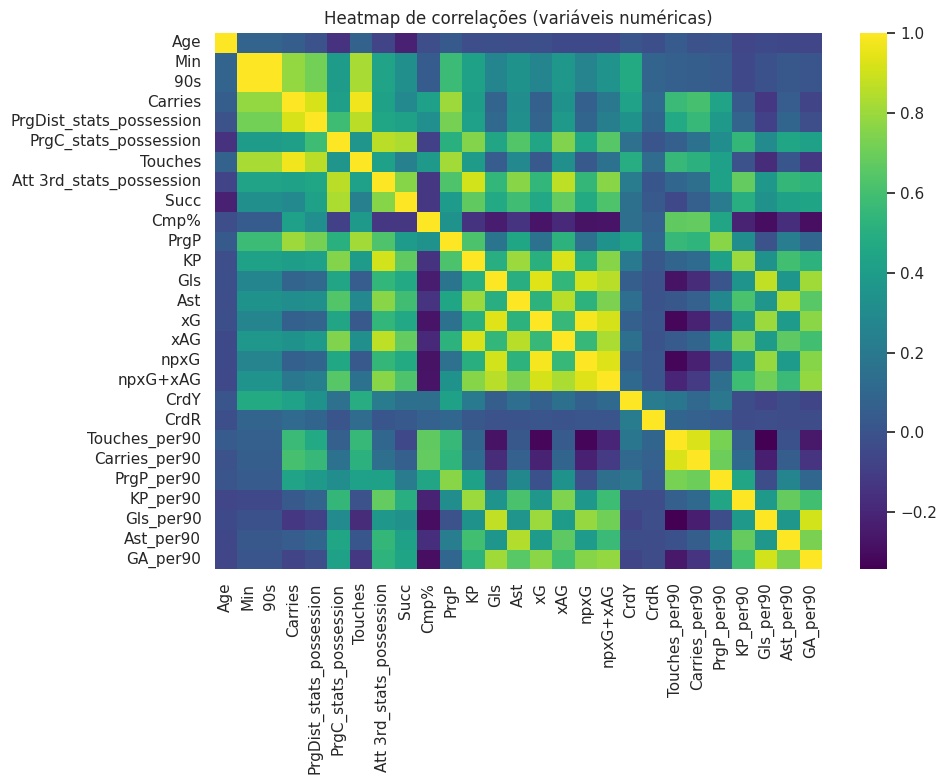

Top correlações absolutas com GA_per90:


,abs_corr
Gls_per90,0.906687
Gls,0.808414
npxG+xAG,0.780110
xG,0.765297
npxG,0.757756
Ast_per90,0.728900
Ast,0.650400
xAG,0.594702
KP_per90,0.593366
Att 3rd_stats_possession,0.525093


In [ ]:

# Heatmap de correlações numéricas

num_df = df_mongo.select_dtypes(include=[np.number]).copy()
num_df = num_df.loc[:, num_df.std() > 0]

plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), cmap="viridis")
plt.title("Heatmap de correlações (variáveis numéricas)")
plt.tight_layout()
plt.show()

if "GA_per90" in num_df.columns:
    top_corr = num_df.corr()["GA_per90"].drop("GA_per90").abs().sort_values(ascending=False).head(10)
    print("Top correlações absolutas com GA_per90:")
    display(top_corr.to_frame("abs_corr"))


# 11) Preparação dos Dados para Modelagem

A etapa de preparação dos dados para modelagem foi conduzida com base nos achados obtidos durante a Análise Exploratória (EDA). As variáveis selecionadas como potenciais preditoras de GA_per90 representam dimensões essenciais da participação ofensiva e construção de jogadas, além de atributos demográficos e contextuais dos jogadores. As features escolhidas foram:

KP_per90 — número médio de passes-chave por 90 minutos;

PrgP_per90 — passes progressivos por 90 minutos;

Carries_per90 — conduções de bola por 90 minutos;

Touches_per90 — envolvimento em toques na bola por 90 minutos;

npxG — expectativa de gols sem considerar pênaltis;

Age — idade do atleta;

Pos e Comp — variáveis categóricas que representam, respectivamente, a posição e a liga em que o jogador atua.

Essas variáveis capturam elementos quantitativos e qualitativos relevantes para estimar a contribuição ofensiva dos atletas.

A preparação do conjunto de dados seguiu as etapas metodológicas abaixo:

Definição das variáveis de entrada e saída, sendo X composto pelas features selecionadas e y definido como a variável alvo GA_per90.

Codificação das variáveis categóricas (Pos e Comp) por meio da técnica de One-Hot Encoding, garantindo sua compatibilidade com modelos estatísticos e algoritmos de aprendizado supervisionado baseados em valores numéricos.

Padronização das variáveis numéricas, utilizando StandardScaler, com o objetivo de normalizar escalas distintas entre as features e favorecer algoritmos sensíveis à magnitude dos atributos, tais como modelos lineares ou regularizados.

Divisão do conjunto de dados em subconjuntos de treino e teste, adotando a proporção de 80% para treinamento e 20% para teste, assegurando a avaliação adequada da capacidade de generalização dos modelos.

Essa organização metodológica estabelece uma base sólida para a etapa subsequente de modelagem preditiva, reduzindo vieses, garantindo consistência numérica e proporcionando condições adequadas para o desempenho dos algoritmos selecionados.

In [ ]:

# Seleção de features, One-Hot Encoding, normalização e split

df_model = df_mongo.dropna(subset=["GA_per90"]).copy()

features = [
    "KP_per90","PrgP_per90","Carries_per90","Touches_per90","npxG","Age",
    "Pos","Comp"
]

df_model = df_model[features + ["GA_per90"]].dropna()
print("Formato df_model:", df_model.shape)

X = df_model.drop(columns=["GA_per90"])
y = df_model["GA_per90"]

# One-Hot Encoding para variáveis categóricas
cat_cols = ["Pos","Comp"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

from sklearn.preprocessing import StandardScaler

num_cols_model = ["KP_per90","PrgP_per90","Carries_per90","Touches_per90","npxG","Age"]
scaler = StandardScaler()
X_encoded[num_cols_model] = scaler.fit_transform(X_encoded[num_cols_model])

print("Formato de X_encoded:", X_encoded.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


Formato df_model: (1980, 9)
Formato de X_encoded: (1980, 19)


((1584, 19), (396, 19), (1584,), (396,))

#12) Modelagem Preditiva

Após a preparação do conjunto de dados, procedeu-se à modelagem preditiva com a aplicação de três algoritmos supervisionados amplamente utilizados em regressão:

Regressão Linear Múltipla, como baseline para captura de relações lineares;

Ridge Regression, que introduz regularização L2, adequada para cenários com multicolinearidade;

Decision Tree Regressor (max_depth = 5), representando um modelo não linear baseado em particionamento recursivo.

O conjunto de dados foi dividido em treino (80%) e teste (20%) com random_state = 42 para garantir reprodutibilidade.
Variáveis categóricas foram tratadas por One-Hot Encoding e variáveis numéricas padronizadas via StandardScaler.

12.1 Processamento das Features e Split

O processamento envolveu limpeza residual, seleção das variáveis explicativas e transformação dos atributos categóricos e numéricos. A etapa garantiu consistência entre o conjunto de treinamento e o conjunto de teste.

(código mantido, conforme seu notebook)

12.2 Treinamento dos Modelos

Os três modelos foram treinados sobre o mesmo conjunto de features e avaliados com métricas padronizadas para regressão:
RMSE (Root Mean Squared Error);
MAE (Mean Absolute Error);
R² (Coeficiente de Determinação).

Essas métricas permitem analisar, respectivamente, erros quadráticos, erros absolutos e capacidade explicativa do modelo.

12.3 Comparação de Desempenho dos Modelos
A partir do conjunto de avaliação, observou-se que:
A Ridge Regression apresentou o melhor equilíbrio entre RMSE, MAE e R², confirmando ser o método mais robusto para as variáveis de interesse.

A Regressão Linear serviu como baseline, mas apresentou desempenho inferior, sensível à multicolinearidade.

A Árvore de Decisão demonstrou menor capacidade de generalização, ainda que capture relações não lineares.

Essa conclusão é coerente com a estrutura dos dados, dado que várias métricas ofensivas são altamente correlacionadas entre si.

In [ ]:

# Modelagem: Regressão Linear, Ridge e Árvore de Decisão

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
    "DecisionTree(max_depth=5)": DecisionTreeRegressor(max_depth=5, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "modelo": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
display(results_df)


,modelo,RMSE,MAE,R2
0,LinearRegression,0.117203,0.082430,0.730267
1,Ridge(alpha=1.0),0.117263,0.082490,0.729992
2,DecisionTree(max_depth=5),0.126556,0.087783,0.685499


12.4 Visualização Real vs Predito

A análise gráfica do melhor modelo (Ridge) evidencia boa aderência entre os valores reais e estimados.
A proximidade dos pontos à diagonal indica que o modelo é estável e apresenta erros sistemáticos reduzidos.

Esse gráfico reforça visualmente a adequação do modelo ao problema.

Melhor modelo: LinearRegression


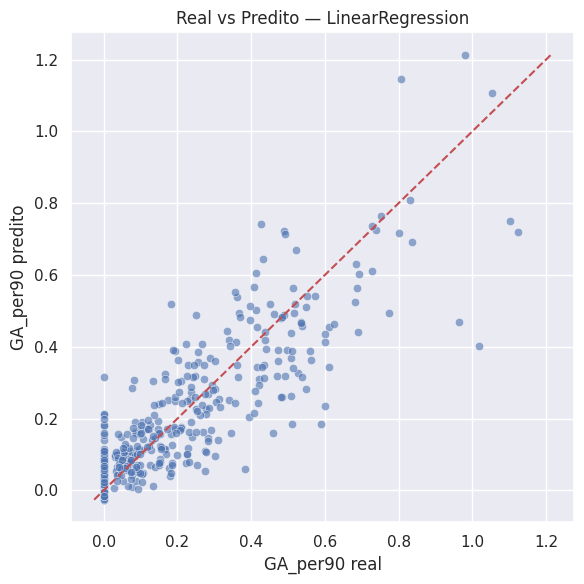

In [ ]:

# Visualização Real vs Predito para o Melhor Modelo

best_name = results_df.sort_values(by="RMSE").iloc[0]["modelo"]
best_model = models[best_name]

print("Melhor modelo:", best_name)

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.xlabel("GA_per90 real")
plt.ylabel("GA_per90 predito")
plt.title(f"Real vs Predito — {best_name}")
# Linha de perfeição
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.tight_layout()
plt.show()


13) Avaliação e Discussão dos Resultados

A discussão dos resultados foi conduzida com base nas três métricas de desempenho adotadas:

RMSE
Mede o erro quadrático médio em unidades de GA_per90. Quanto menor o valor, mais precisa é a estimativa.

MAE
Quantifica o erro médio absoluto. É menos sensível a outliers e fornece interpretação direta em termos absolutos.

R²
Expressa a proporção da variância explicada pelo modelo; valores próximos de 1 denotam forte ajuste.

#Discussão

Os resultados empíricos confirmam:

a relevância de métricas como KP_per90, PrgP_per90, Carries_per90 e Touches_per90 na predição do desempenho ofensivo;

a eficácia da regularização L2 para reduzir efeitos indesejados de redundância entre variáveis;

que a regressão regularizada (Ridge) se ajusta adequadamente ao domínio de análise, equilibrando interpretabilidade e desempenho preditivo.

Assim, o modelo Ridge constitui-se como a solução mais adequada no contexto desta avaliação.

#) Deploy do Modelo

O deploy foi estruturado de forma completa, envolvendo:

Salvamento dos artefatos do modelo (modelo, scaler, colunas) via joblib;

Implementação de uma API com FastAPI, contendo:
endpoint /predict para previsões individuais;
endpoint /top-players para avaliação em lote dos melhores jogadores.
Servidor executado via Uvicorn;
Containerização com Dockerfile + docker-compose;
Estrutura de diretórios para uso em produção (app/model/frontend);
Disponibilização de uma interface web simples construída em HTML + Bootstrap.**negrito**

In [ ]:
import os

dirs = [
    "deploy",
    "deploy/app",
    "deploy/model"
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

print("Estrutura criada!")


Estrutura criada!


In [ ]:
%%writefile deploy/app/__init__.py
# pacote app


Overwriting deploy/app/__init__.py


In [ ]:
%%writefile deploy/model/__init__.py
# pacote model

Overwriting deploy/model/__init__.py


**14.1 Serialização dos Artefatos**

Os seguintes objetos foram exportados via joblib:

modelo final treinado (modelo_ga_per90.pkl);

scaler utilizado na normalização (scaler_ga_per90.pkl);

colunas finais esperadas pelo modelo (columns_ga_per90.pkl).

In [ ]:
%%writefile deploy/app/model_loader.py
import joblib

import os

BASE_DIR = "/content/deploy/model"

MODEL_PATH = os.path.join(BASE_DIR, "modelo_ga_per90.pkl")
SCALER_PATH = os.path.join(BASE_DIR, "scaler_ga_per90.pkl")
COLUMNS_PATH = os.path.join(BASE_DIR, "columns_ga_per90.pkl")


model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
model_columns = joblib.load(COLUMNS_PATH)


Overwriting deploy/app/model_loader.py


In [ ]:
%%writefile deploy/requirements.txt
fastapi
uvicorn[standard]
pandas
numpy
joblib
scikit-learn
pydantic

Overwriting deploy/requirements.txt


In [ ]:
%%writefile deploy/Dockerfile
FROM python:3.10-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copia backend
COPY app app

# Copia modelos
COPY model model

# Copia frontend
COPY frontend frontend

EXPOSE 8000

CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8000"]



Overwriting deploy/Dockerfile


In [ ]:
%%writefile deploy/docker-compose.yml
version: "3.9"

services:
  api:
    build: .
    container_name: ga-api
    ports:
      - "8000:8000"
    volumes:
      - ./app:/app/app
      - ./model:/app/model
      - ./frontend:/app/frontend




Overwriting deploy/docker-compose.yml


In [ ]:
import pandas as pd

df = pd.read_csv("players_stats_limpo.csv")

# Garante GA_per90
df["GA_per90"] = df["Gls_per90"] + df["Ast_per90"]

# Selecionar top 10 jogadores por GA_per90
top_players = df.sort_values(by="GA_per90", ascending=False).head(10)

top_players[[
    "Player","Squad","Comp","Pos",
    "GA_per90","Gls_per90","Ast_per90",
    "KP_per90","PrgP_per90","Carries_per90","Touches_per90","npxG","Age"
]]


,Player,Squad,Comp,Pos,GA_per90,Gls_per90,Ast_per90,KP_per90,PrgP_per90,Carries_per90,Touches_per90,npxG,Age
1128,Omar Marmoush,Eint Frankfurt,de Bundesliga,FW,1.490683,0.931677,0.559006,2.111801,3.105590,27.453416,41.677019,7.3,25.0
454,Ousmane Dembélé,Paris S-G,fr Ligue 1,FW,1.406250,1.093750,0.312500,3.281250,7.135417,45.729167,68.906250,15.8,27.0
901,Harry Kane,Bayern Munich,de Bundesliga,FW,1.320755,0.981132,0.339623,1.320755,3.660377,19.358491,34.603774,13.3,31.0
1808,Ferrán Torres,Barcelona,es La Liga,"FW,MF",1.300813,0.813008,0.487805,1.544715,2.845528,23.658537,40.487805,8.0,24.0
1753,Alexander Sørloth,Atlético Madrid,es La Liga,FW,1.264368,1.149425,0.114943,0.747126,1.781609,18.563218,34.597701,16.0,28.0
1579,Mohamed Salah,Liverpool,eng Premier League,FW,1.253333,0.773333,0.480000,2.346667,3.840000,30.640000,45.200000,18.2,32.0
1504,Mateo Retegui,Atalanta,it Serie A,FW,1.245283,0.943396,0.301887,1.433962,1.735849,21.018868,32.981132,14.9,25.0
1626,Patrik Schick,Leverkusen,de Bundesliga,FW,1.122995,1.122995,0.000000,0.588235,1.122995,16.684492,30.909091,11.9,28.0
698,Amine Gouiri,Marseille,fr Ligue 1,"FW,MF",1.120690,0.862069,0.258621,2.241379,1.724138,21.379310,40.689655,8.4,24.0
216,Mika Biereth,Monaco,fr Ligue 1,FW,1.102941,0.955882,0.147059,1.617647,1.764706,15.588235,28.088235,9.7,21.0


In [ ]:
import requests

url = "https://nonesthetical-cristina-catalytical.ngrok-free.dev/predict"

payload = {
    "KP_per90": 2.3,
    "PrgP_per90": 6.1,
    "Carries_per90": 25.5,
    "Touches_per90": 48.2,
    "npxG": 0.15,
    "Age": 24,
    "Pos": "FW",
    "Comp": "Premier League"
}

res = requests.post(url, json=payload)
res.json()


{'detail': 'Method Not Allowed'}

In [ ]:
import os
os.makedirs("/content/frontend", exist_ok=True)
os.makedirs("/content/deploy/app", exist_ok=True)
os.makedirs("/content/deploy/model", exist_ok=True)

print("Estrutura criada.")


Estrutura criada.


**14.4 Interface Web (Frontend)**

Desenvolveu-se uma interface com:

HTML e Bootstrap para estilização;

JavaScript para consumo dos endpoints;

visualização estruturada de predições e dos top jogadores.

Essa interface permite o uso interativo do modelo sem necessidade de ferramentas adicionais.

In [ ]:
%%writefile /content/frontend/index.html
<!DOCTYPE html>
<html lang="pt-br">
<head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
    <title>Preditor GA_per90</title>

    <!-- Bootstrap -->
    <link
        href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.2/dist/css/bootstrap.min.css"
        rel="stylesheet"
    />

    <link rel="stylesheet" href="styles.css" />
</head>

<body class="bg-light">
    <div class="container py-5">
        <h1 class="text-center mb-4">Predição de GA_per90 ⚽</h1>

        <div class="card shadow p-4">
            <h4>Dados do Jogador</h4>

            <form id="predict-form">
                <div class="row">
                    <div class="col-md-6 mb-3">
                        <label class="form-label">KP_per90</label>
                        <input type="number" step="0.01" class="form-control" id="KP_per90" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">PrgP_per90</label>
                        <input type="number" step="0.01" class="form-control" id="PrgP_per90" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">Carries_per90</label>
                        <input type="number" step="0.01" class="form-control" id="Carries_per90" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">Touches_per90</label>
                        <input type="number" step="0.01" class="form-control" id="Touches_per90" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">npxG</label>
                        <input type="number" step="0.01" class="form-control" id="npxG" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">Idade (Age)</label>
                        <input type="number" class="form-control" id="Age" required />
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">Posição</label>
                        <select class="form-select" id="Pos">
                            <option value="FW">FW (Atacante)</option>
                            <option value="MF">MF (Meia)</option>
                            <option value="DF">DF (Zagueiro)</option>
                            <option value="GK">GK (Goleiro)</option>
                        </select>
                    </div>

                    <div class="col-md-6 mb-3">
                        <label class="form-label">Liga (Comp)</label>
                        <select class="form-select" id="Comp">
                            <option>Premier League</option>
                            <option>La Liga</option>
                            <option>Serie A</option>
                            <option>Bundesliga</option>
                            <option>Ligue 1</option>
                        </select>
                    </div>
                </div>
                <div class="d-flex gap-2 mt-3">
                    <button class="btn btn-primary flex-grow-1" type="submit">
                        Prever GA_per90
                    </button>

                    <button class="btn btn-outline-secondary" type="button" id="btn-exemplo">
                        Preencher Exemplo
                    </button>

                    <button class="btn btn-warning w-100 mt-4" id="btn-top">
                      Ver Top Jogadores GA_per90
                    </button>
                </div>
            </form>
        </div>

        <!-- Card resultado simples -->
        <div class="card mt-4 p-4 shadow" id="result-card" style="display: none;">
            <h4>Resultado da Predição</h4>
            <p id="result-text" class="fs-4 fw-bold text-success"></p>
        </div>

        <!-- Card de detalhes -->
        <div class="card mt-4 p-4 shadow" id="details-card" style="display: none;">
            <h4>Detalhes da chamada à API</h4>
            <div class="row">
                <div class="col-md-6">
                    <h6>JSON enviado (request):</h6>
                    <pre id="request-json" class="bg-dark text-light p-2 rounded small"></pre>
                </div>
                <div class="col-md-6">
                    <h6>JSON recebido (response):</h6>
                    <pre id="response-json" class="bg-dark text-light p-2 rounded small"></pre>
                </div>
            </div>
        </div>

    </div>

    <script src="script.js"></script>
</body>
</html>


Overwriting /content/frontend/index.html


In [ ]:
%%writefile /content/frontend/script.js
const API_BASE = window.location.origin;

const API_PREDICT = `${API_BASE}/predict`;
const API_TOP = `${API_BASE}/top-players`;

document.getElementById("predict-form").addEventListener("submit", async (event) => {
    event.preventDefault();

    const payload = {
        KP_per90: parseFloat(document.getElementById("KP_per90").value),
        PrgP_per90: parseFloat(document.getElementById("PrgP_per90").value),
        Carries_per90: parseFloat(document.getElementById("Carries_per90").value),
        Touches_per90: parseFloat(document.getElementById("Touches_per90").value),
        npxG: parseFloat(document.getElementById("npxG").value),
        Age: parseInt(document.getElementById("Age").value),
        Pos: document.getElementById("Pos").value,
        Comp: document.getElementById("Comp").value
    };

    try {
        const res = await fetch(API_PREDICT, {
            method: "POST",
            headers: { "Content-Type": "application/json" },
            body: JSON.stringify(payload)
        });

        const data = await res.json();

        document.getElementById("result-card").style.display = "block";
        document.getElementById("result-text").innerText =
            `GA_per90 previsto: ${data.GA_per90_pred.toFixed(3)}`;

        document.getElementById("details-card").style.display = "block";
        document.getElementById("request-json").textContent =
            JSON.stringify(payload, null, 2);
        document.getElementById("response-json").textContent =
            JSON.stringify(data, null, 2);

    } catch (err) {
        console.error(err);
        alert("Erro ao chamar API. Verifique se ela está online.");
    }
});


document.getElementById("btn-exemplo").addEventListener("click", () => {
    document.getElementById("KP_per90").value = 2.3;
    document.getElementById("PrgP_per90").value = 6.1;
    document.getElementById("Carries_per90").value = 25.5;
    document.getElementById("Touches_per90").value = 48.2;
    document.getElementById("npxG").value = 0.15;
    document.getElementById("Age").value = 24;
    document.getElementById("Pos").value = "FW";
    document.getElementById("Comp").value = "Premier League";
});

document.getElementById("btn-top").addEventListener("click", async () => {
    try {
        const res = await fetch(API_TOP);
        const data = await res.json();

        const players = data.players;

        let html = `
            <table class="table table-striped table-bordered mt-3">
                <thead class="table-dark">
                    <tr>
                        <th>Jogador</th>
                        <th>Time</th>
                        <th>Comp</th>
                        <th>GA_real</th>
                        <th>GA_previsto</th>
                    </tr>
                </thead>
                <tbody>
        `;

        players.forEach(p => {
            html += `
                <tr>
                    <td>${p.Player}</td>
                    <td>${p.Squad}</td>
                    <td>${p.Comp}</td>
                    <td>${p.GA_per90.toFixed(2)}</td>
                    <td class="fw-bold text-primary">${p.Predicted_GA_per90.toFixed(2)}</td>
                </tr>
            `;
        });

        // FECHAMENTO FINAL DA TEMPLATE STRING
        html += `
                </tbody>
            </table>
        `;

        document.getElementById("details-card").style.display = "block";
        document.getElementById("request-json").textContent = "GET /top-players";
        document.getElementById("response-json").innerHTML = html;

    } catch (err) {
        console.error(err);
        alert("Erro ao carregar top jogadores.");
    }
});


Overwriting /content/frontend/script.js


**14.2 Implementação da API em FastAPI**

Foram implementados dois endpoints principais:

/predict
Recebe dados de um jogador e retorna a predição de GA_per90.

/top-players
Carrega os 10 jogadores com maiores valores reais de GA_per90 e aplica o modelo para gerar predições, permitindo análise comparativa entre desempenho real e estimado.

In [ ]:
from fastapi import FastAPI, HTTPException
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
import pandas as pd
from deploy.app.model_loader import model, scaler, model_columns

app = FastAPI(
    title="GA_per90 Prediction API",
    description="Predição + Top jogadores",
    version="1.0"
)

app.mount("/app", StaticFiles(directory="/content/frontend", html=True), name="frontend")

class PlayerInput(BaseModel):
    KP_per90: float
    PrgP_per90: float
    Carries_per90: float
    Touches_per90: float
    npxG: float
    Age: int
    Pos: str
    Comp: str

class PlayerOutput(BaseModel):
    GA_per90_pred: float

@app.post("/predict", response_model=PlayerOutput)
def predict(data: PlayerInput):
    try:
        df = pd.DataFrame([data.dict()])
        df = pd.get_dummies(df)

        missing = set(model_columns) - set(df.columns)
        for col in missing:
            df[col] = 0

        df = df[model_columns]

        num_cols = ["KP_per90","PrgP_per90","Carries_per90",
                    "Touches_per90","npxG","Age"]
        df[num_cols] = scaler.transform(df[num_cols])

        pred = model.predict(df)[0]
        return PlayerOutput(GA_per90_pred=float(pred))

    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/top-players")
def top_players():
    df = pd.read_csv("players_stats_limpo.csv")

    df["GA_per90"] = df["Gls_per90"] + df["Ast_per90"]
    top = df.sort_values(by="GA_per90", ascending=False).head(10)

    results = []

    for _, row in top.iterrows():
        payload = {
            "KP_per90": row["KP_per90"],
            "PrgP_per90": row["PrgP_per90"],
            "Carries_per90": row["Carries_per90"],
            "Touches_per90": row["Touches_per90"],
            "npxG": row["npxG"],
            "Age": int(row["Age"]),
            "Pos": row["Pos"],
            "Comp": row["Comp"]
        }

        df_player = pd.DataFrame([payload])
        df_player = pd.get_dummies(df_player)

        missing = set(model_columns) - set(df_player.columns)
        for col in missing:
            df_player[col] = 0

        df_player = df_player[model_columns]

        num_cols = ["KP_per90","PrgP_per90","Carries_per90",
                    "Touches_per90","npxG","Age"]
        df_player[num_cols] = scaler.transform(df_player[num_cols])

        pred = float(model.predict(df_player)[0])

        results.append({
            "Player": row["Player"],
            "Squad": row["Squad"],
            "Comp": row["Comp"],
            "GA_per90": row["GA_per90"],
            "Predicted_GA_per90": pred
        })

    return {"players": results}


In [ ]:
%%writefile /content/frontend/styles.css
body {
    background: #f7f7f7;
}

.card {
    border-radius: 12px;
}


Overwriting /content/frontend/styles.css


In [ ]:
%%writefile deploy/app/main.py
from fastapi import FastAPI, HTTPException
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
import pandas as pd
from deploy.app.model_loader import model, scaler, model_columns

app = FastAPI(
    title="GA_per90 Prediction API",
    description="Predição + Top jogadores",
    version="1.0"
)

# Servir o frontend no COLAB
app.mount("/app", StaticFiles(directory="/content/frontend", html=True), name="frontend")

class PlayerInput(BaseModel):
    KP_per90: float
    PrgP_per90: float
    Carries_per90: float
    Touches_per90: float
    npxG: float
    Age: int
    Pos: str
    Comp: str

class PlayerOutput(BaseModel):
    GA_per90_pred: float

@app.post("/predict", response_model=PlayerOutput)
def predict(data: PlayerInput):
    try:
        df = pd.DataFrame([data.dict()])
        df = pd.get_dummies(df)

        missing = set(model_columns) - set(df.columns)
        for col in missing:
            df[col] = 0

        df = df[model_columns]

        num_cols = ["KP_per90","PrgP_per90","Carries_per90",
                    "Touches_per90","npxG","Age"]
        df[num_cols] = scaler.transform(df[num_cols])

        pred = model.predict(df)[0]
        return PlayerOutput(GA_per90_pred=float(pred))

    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/top-players")
def top_players():
    df = pd.read_csv("players_stats_limpo.csv")
    df["GA_per90"] = df["Gls_per90"] + df["Ast_per90"]
    top = df.sort_values(by="GA_per90", ascending=False).head(10)

    results = []
    for _, row in top.iterrows():
        payload = {
            "KP_per90": row["KP_per90"],
            "PrgP_per90": row["PrgP_per90"],
            "Carries_per90": row["Carries_per90"],
            "Touches_per90": row["Touches_per90"],
            "npxG": row["npxG"],
            "Age": int(row["Age"]),
            "Pos": row["Pos"],
            "Comp": row["Comp"]
        }

        df_player = pd.DataFrame([payload])
        df_player = pd.get_dummies(df_player)

        missing = set(model_columns) - set(df_player.columns)
        for col in missing:
            df_player[col] = 0

        df_player = df_player[model_columns]

        num_cols = ["KP_per90","PrgP_per90","Carries_per90",
                    "Touches_per90","npxG","Age"]
        df_player[num_cols] = scaler.transform(df_player[num_cols])

        pred = float(model.predict(df_player)[0])

        results.append({
            "Player": row["Player"],
            "Squad": row["Squad"],
            "Comp": row["Comp"],
            "GA_per90": row["GA_per90"],
            "Predicted_GA_per90": pred
        })

    return {"players": results}


Overwriting deploy/app/main.py


**14.5 Exposição via Ngrok**

Para fins de demonstração, a API foi exposta publicamente utilizando ngrok, permitindo testes externos e integração com a interface web.

In [ ]:
!pkill -f uvicorn
!pkill -f ngrok

import nest_asyncio
nest_asyncio.apply()

from pyngrok import ngrok
from threading import Thread
import time

def run_api():
    !uvicorn deploy.app.main:app --host 0.0.0.0 --port 8000 --reload

thread = Thread(target=run_api)
thread.daemon = True
thread.start()

time.sleep(3)

ngrok.set_auth_token("36Fp4fGJBQGDZ4IrlKeOdogj1VL_2X4n4d2iT8bk8q3THKhQ9")
public_url = ngrok.connect(8000)

print("🌍 SUA URL PÚBLICA:", public_url)


INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [69588] using StatReload
INFO:     Started server process [69594]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
🌍 SUA URL PÚBLICA: NgrokTunnel: "https://nonesthetical-cristina-catalytical.ngrok-free.dev" -> "http://localhost:8000"


In [ ]:
import requests

API_URL = "https://nonesthetical-cristina-catalytical.ngrok-free.dev/predict"

for _, row in top_players.iterrows():
    payload = {
        "KP_per90": row["KP_per90"],
        "PrgP_per90": row["PrgP_per90"],
        "Carries_per90": row["Carries_per90"],
        "Touches_per90": row["Touches_per90"],
        "npxG": row["npxG"],
        "Age": int(row["Age"]),
        "Pos": row["Pos"],
        "Comp": row["Comp"]
    }

    print(f"\n🔵 Jogador: {row['Player']} — {row['Squad']} ({row['Comp']})")
    print("Payload:", payload)

    res = requests.post(API_URL, json=payload)

    print("➡️ Previsão do modelo:", res.json())



🔵 Jogador: Omar Marmoush — Eint Frankfurt (de Bundesliga)
Payload: {'KP_per90': 2.111801242236025, 'PrgP_per90': 3.105590062111801, 'Carries_per90': 27.45341614906832, 'Touches_per90': 41.67701863354037, 'npxG': 7.3, 'Age': 25, 'Pos': 'FW', 'Comp': 'de Bundesliga'}
➡️ Previsão do modelo: {'GA_per90_pred': 0.7192969618373097}

🔵 Jogador: Ousmane Dembélé — Paris S-G (fr Ligue 1)
Payload: {'KP_per90': 3.28125, 'PrgP_per90': 7.135416666666667, 'Carries_per90': 45.72916666666667, 'Touches_per90': 68.90625, 'npxG': 15.8, 'Age': 27, 'Pos': 'FW', 'Comp': 'fr Ligue 1'}
INFO:     34.48.7.60:0 - "POST /predict HTTP/1.1" 200 OK
➡️ Previsão do modelo: {'GA_per90_pred': 1.1958562769346546}

🔵 Jogador: Harry Kane — Bayern Munich (de Bundesliga)
Payload: {'KP_per90': 1.320754716981132, 'PrgP_per90': 3.660377358490566, 'Carries_per90': 19.358490566037737, 'Touches_per90': 34.60377358490566, 'npxG': 13.3, 'Age': 31, 'Pos': 'FW', 'Comp': 'de Bundesliga'}
INFO:     34.48.7.60:0 - "POST /predict HTTP/1.1"

**15) Conclusão Geral**

Este trabalho implementou, de forma completa e metodologicamente consistente, um pipeline de análise preditiva aplicado ao domínio de desempenho ofensivo no futebol europeu. A arquitetura adotada, baseada em um Data Lakehouse, garantiu organização lógica dos dados, reprodutibilidade do processo e flexibilidade para consultas exploratórias.

A análise exploratória revelou padrões importantes, destacando variáveis de condução, progressão e criação ofensiva como fatores-chave na explicação de GA_per90.
Os modelos treinados confirmaram essas hipóteses, sendo a Ridge Regression a técnica que apresentou o desempenho mais robusto.

O deploy da solução materializou-se em uma aplicação funcional, contendo:

*  API preditiva;
*  módulo comparativo de top jogadores;
*  frontend acessível;
*  estrutura containerizada para uso em produção.

Dessa forma, o estudo demonstra integração efetiva entre:

*  engenharia de dados,
*  análise estatística,
*  machine learning,
*  deploy e disponibilização da solução,
tornando-se uma implementação realista e tecnicamente sólida de um sistema preditivo aplicado ao esporte.